<a href="https://colab.research.google.com/github/arbirdi/IRC_Generative_Medical_imaging/blob/main/Rewritten_2_0_120x120_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:

see: https://www.tensorflow.org/tutorials/generative/dcgan

## Module Imports

In [ ]:
!pip install imageio
!pip install git+https://github.com/tensorflow/docs
!pip install PIL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-7rnmkbfq
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-7rnmkbfq
  Resolved https://github.com/tensorflow/docs to commit 63191f2e07e92aefc9da30f442465e55e7eb7d07
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=182559 sha256=8323a45db556711b35841dfebe7cddc0d70d6b77ba69a3b6a8b8d11044a41968
  Stored in directory: /tmp/pip-ephem-wheel-cache-q6q4p6zf/wheels/fc/f8/3b/5d21409a59cb1be9b1ade11f682039ced75b84de9dd6a0c8de
Successfully built tensorflow-docs
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time
from IPython import display

## Tensorflow Setup

In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.11.0'

In [ ]:
"""physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)"""

'physical_devices = tf.config.list_physical_devices("GPU")\ntf.config.experimental.set_memory_growth(physical_devices[0], True)'

## Data Cleaning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/IRC

/content/drive/MyDrive/IRC


In [ ]:
#import data
train_images_original = np.load('2d_data.npy')
train_labels = np.load('2d_label.npy')

In [ ]:
#load data

(4455, 240, 240, 1)


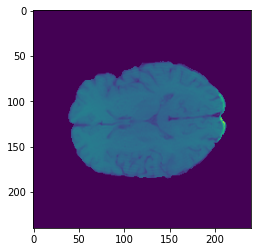

In [ ]:
#clean data
print(train_images_original.shape)
plt.imshow(train_images_original[0])

In [ ]:
from sklearn import preprocessing
import scipy as sp
import copy

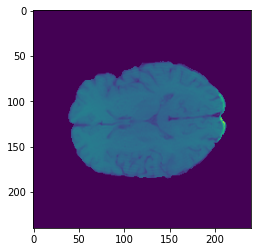

{'whiskers': [<matplotlib.lines.Line2D at 0x7fef827b0490>,
 'caps': [<matplotlib.lines.Line2D at 0x7fef827b0cd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fef827b02b0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fef8279d940>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fef8279d100>],
 'means': []}

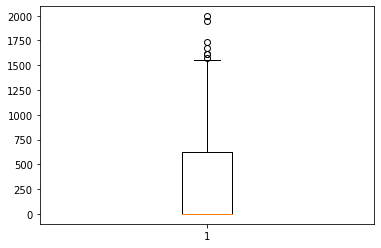

In [ ]:
plt.imshow(train_images_original[0].reshape(240,240))
plt.show()
plt.boxplot(train_images_original[0].flatten())

(array([4.0000e+04, 2.7600e+02, 2.0860e+03, 1.4097e+04, 1.0330e+03,
        4.9000e+01, 4.3000e+01, 1.0000e+01, 4.0000e+00, 2.0000e+00]),
 array([   0.        ,  199.47396851,  398.94793701,  598.421875  ,
         797.89587402,  997.36981201, 1196.84375   , 1396.31774902,
        1595.79174805, 1795.265625  , 1994.73962402]),
 <BarContainer object of 10 artists>)

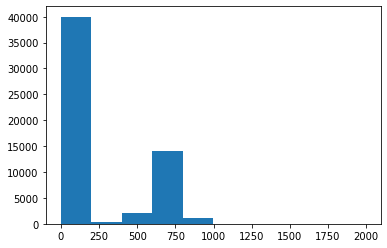

In [ ]:
plt.hist(train_images_original[0].flatten())

In [ ]:
"""train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]"""

training_image = np.zeros(shape=(240,240))
resized_training_images = np.zeros(shape=(train_images_original.shape[0], 120,120, 1))#train_images.shape[1]/2, train_images.shape[2]/2, 1))
train_images = copy.deepcopy(train_images_original)
logit_lmbda = lambda x: np.log(x/(1-x)) #sp.special.logit(x)
logit_vfunc = np.vectorize(logit_lmbda)
a, b = 0.5, 0.99
c=b-a
for i in range(train_images.shape[0]):
    train_images[i] = train_images[i]/max(train_images[i].flatten()) #normalise images to [0,1] - possibly in the future change this to [-1, 1]
    train_images[i] = (train_images[i]*(c)) + a #turn images to [0.05, 0.95]
    #train_images[i] = (train_images[i]*2)-1 #scaled to [-1,1]
    train_images[i] = np.log(train_images[i]/(1-train_images[i]))
    #train_images[i] = train_images[i]/max(train_images[i].flatten())
    #train_images[i] = (train_images[i]*(c))+a
    #train_images[i] = np.log(train_images[i]/(1-train_images[i]))
    #train_images[i] = logit_vfunc(train_images[i])
    #scaler = preprocessing.StandardScaler().fit(train_images[i].flatten().reshape(-1,1))
    #training_image = scaler.transform(train_images[i].flatten().reshape(-1,1)).reshape(240,240)
    #training_image = training_image.reshape(240,240,1)
    #training_image[training_image > 3] = 3
    #train_images[i] = scaler.transform(train_images[i].flatten).reshape(120,120,1)
    resized_training_images[i] = train_images[i,::2,::2,:]#training_image[::2,::2,:]

(array([4.0013e+04, 5.7100e+02, 5.7510e+03, 1.1108e+04, 6.0000e+01,
        4.7000e+01, 2.9000e+01, 1.0000e+01, 5.0000e+00, 2.0000e+00,
        2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.        , 0.22975604, 0.45951208, 0.68926811, 0.91902417,
        1.14878023, 1.37853622, 1.60829234, 1.83804834, 2.06780434,
        2.29756045, 2.52731657, 2.75707245, 2.98682857, 3.21658468,
        3.44634056, 3.67609668, 3.90585279, 4.13560867, 4.36536503,
        4.59512091]),
 <BarContainer object of 20 artists>)

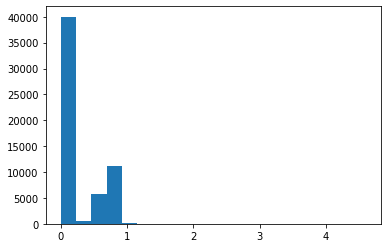

In [ ]:
plt.hist(train_images[0].flatten(), bins=20)

In [ ]:
"""print(list(set(train_images_original[0].flatten())))

min_scan_intensity = []
for el in train_images_original:
  min_scan_intensity.append(list(set(el.flatten()))[1])"""

[0.0, 120.018456, 121.27028, 124.71279, 137.4266, 146.58057, 156.63426, 157.18193, 156.51689, 156.82985, 160.70268, 162.46306, 165.78821, 171.85172, 174.15977, 179.98857, 181.6707, 182.14014, 184.33083, 186.01295, 187.6951, 189.33812, 190.00314, 191.7244, 191.48969, 193.40654, 192.58502, 195.5581, 191.09848, 189.84666, 197.12288, 200.3698, 783.8754, 203.57759, 783.5234, 783.406, 210.6582, 214.60927, 215.00047, 217.73883, 223.09819, 224.54561, 226.65807, 228.96611, 229.78761, 230.88297, 232.5651, 234.7949, 238.74597, 238.90245, 239.09805, 242.77527, 245.67012, 246.96106, 246.06131, 247.27402, 255.48909, 256.62357, 257.75803, 259.04895, 260.30078, 260.65286, 261.9047, 259.714, 261.00494, 265.1125, 264.09537, 260.5355, 268.04645, 269.29825, 270.51096, 273.99258, 274.8141, 274.2273, 276.92654, 277.4742, 278.8043, 279.6258, 280.017, 280.2126, 282.44238, 283.18567, 276.88742, 285.4937, 285.18076, 280.0561, 281.34705, 289.40564, 290.03156, 289.79684, 292.41785, 292.69168, 294.5303, 295.62564,

KeyboardInterrupt: ignored

In [ ]:
#plt.hist(min_scan_intensity, bins =100)

In [ ]:
np.save('logit_brain_images_120', resized_training_images)

In [ ]:
resized_training_images[0]

array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]])

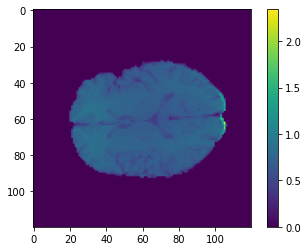

In [ ]:
#plt.imshow(train_images[0])
plt.imshow(resized_training_images[0])
plt.colorbar()
plt.show()

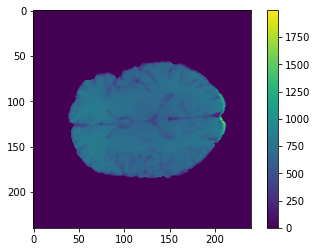

In [ ]:
plt.imshow(train_images_original[0])
plt.colorbar()
plt.show()

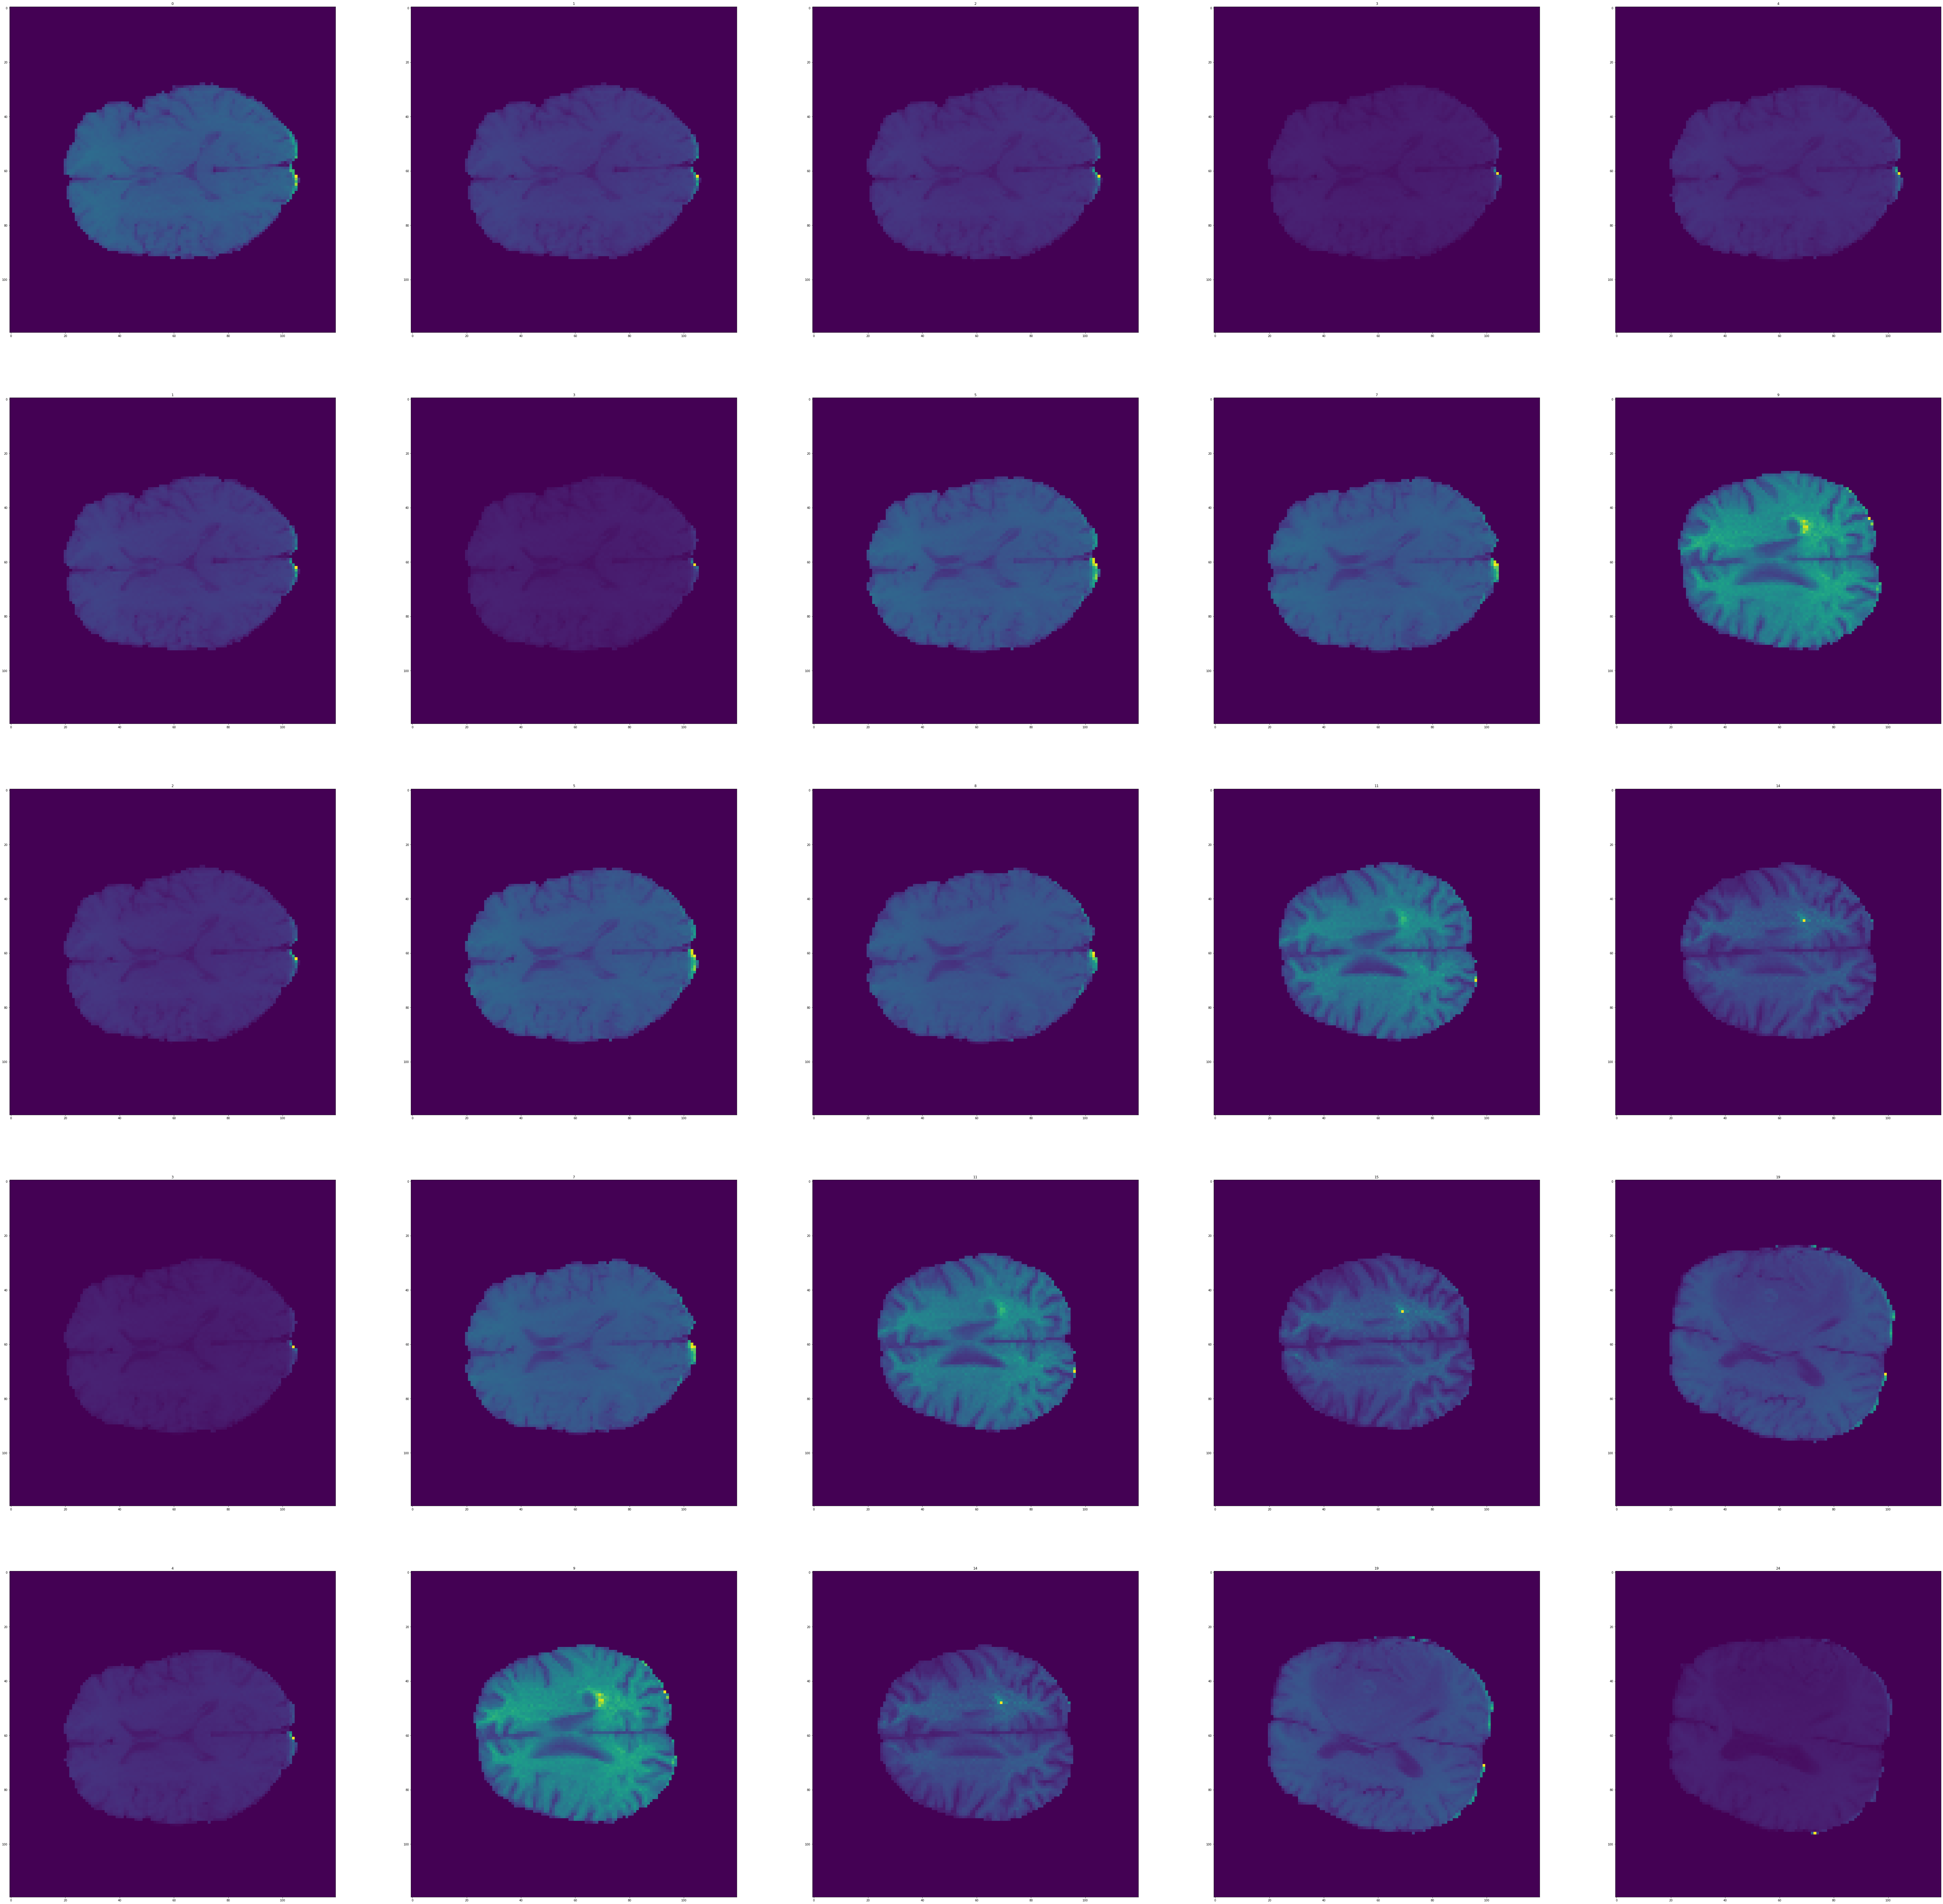

In [ ]:
plt.#plt.imshow(resized_training_images[0])
fig, ax = plt.subplots(ncols=5, nrows=5, figsize=(120,120))
for r in range(5):
    for c in range(5):
        ax[r][c].imshow(resized_training_images[(r+1)*(c+1)-1])
        ax[r][c].title.set_text(f"{(r+1)*(c+1)-1}")
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7fef802571f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fef8028c040>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fef8035ca30>],
 'medians': [<matplotlib.lines.Line2D at 0x7fef806097f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fef8060a4f0>],
 'means': []}

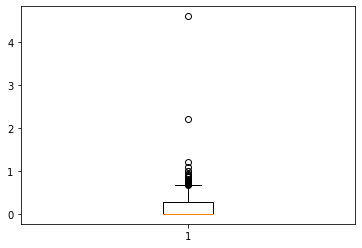

In [ ]:
plt.boxplot(train_images[0].flatten())

{'whiskers': [<matplotlib.lines.Line2D at 0x7f4c6de2eb80>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4c6de3e100>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4c6de2e8e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4c6de3e640>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4c6de3e8e0>],
 'means': []}

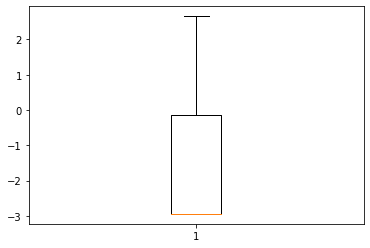

In [ ]:
plt.boxplot(resized_training_images[11].flatten())

{'whiskers': [<matplotlib.lines.Line2D at 0x7f4c6de13700>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4c6de13c40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4c6de52550>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4c6dda81c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4c6dda8460>],
 'means': []}

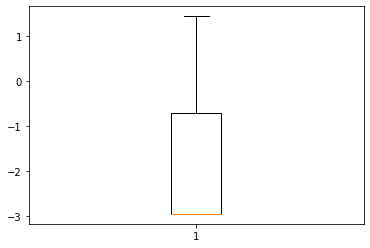

In [ ]:
plt.boxplot(resized_training_images[0].flatten())

In [ ]:
#batch and shuffle data

In [ ]:
BUFFER_SIZE = 4455
BATCH_SIZE = 200
train_dataset = tf.data.Dataset.from_tensor_slices(resized_training_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
print(train_dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, 120, 120, 1), dtype=tf.float64, name=None)>


## The Generator

In [ ]:
latent_dim = 128
def make_generator_model():
    model = tf.keras.Sequential(
        [
            layers.Input(shape=(latent_dim,)),
            layers.Dense(15*15*64),
            layers.Reshape((15,15,64)),
            layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(0.2),
            layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(0.2),
            layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
            layers.LeakyReLU(0.2),
            layers.Conv2DTranspose(1, kernel_size=5, padding="same", activation='sigmoid'),
        ]
    )
    return model

make_generator_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14400)             1857600   
                                                                 
 reshape (Reshape)           (None, 15, 15, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 30, 30, 64)       65600     
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 30, 30, 64)        0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 60, 60, 128)      131200    
 ranspose)                                                       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 60, 60, 128)       0

In [ ]:
noise = tf.random.normal([1, 128])
print(noise)

tf.Tensor(
[[-0.05538476 -1.6758106  -0.49629527  1.0563084  -0.21399975 -1.6932793
   0.12291702 -0.7765841   2.282999   -1.2127885   1.2448248  -1.1420364
  -0.8969081  -0.5881155  -0.7643591   0.4668243  -1.6457816  -0.33987176
  -1.247185   -2.6058218  -0.37172958 -1.8448308  -0.27160674  0.45435786
   1.3121779   1.1991123   0.48419887  0.5190235   0.881615    0.1951541
  -0.287011   -1.23298    -0.34553874  1.6208159   1.2340564  -0.6268126
  -1.6104318   1.2500371   0.73484695  0.6858482  -0.093352   -0.7743651
   0.8975089   0.4014601   0.16549665 -1.0384653  -0.7452238   0.21181008
  -0.64689505 -0.8650858   1.4272228  -2.516363    0.7768859   0.7963502
   2.202019   -1.1035349  -1.3259571  -0.47758555  0.00812336 -1.5953614
  -1.0543413   0.95485544  1.4356275   0.4756714  -0.34986782 -0.44482383
  -0.2983485  -1.1843541  -0.9250496  -0.06949871 -0.2506814   0.7640386
  -1.6519432  -0.12943141 -0.5268878  -1.3686188  -0.8646134   0.59424376
  -0.56527597 -1.0395281  -1.770684

tf.Tensor(
[[-1.7836791  -1.9523484  -0.23336007 -0.55990344  0.41014072 -1.0180423
   0.00570453 -0.3290094   1.0687292  -2.391748   -0.30126885  1.500891
   0.11373747  0.48287883  1.0642626   0.02786583  0.5799639  -0.40220675
  -0.52004474  0.68102443  0.40575138  0.21740288  0.34067073 -0.02443988
   0.09073821  1.9384334   1.4520144   0.8986035   1.9602575  -1.3195409
  -1.3651317   1.7686166  -2.4395313  -0.44532374  0.1656383   0.7558897
   0.26894194 -1.5755876   1.1256362  -1.2817528  -1.228625   -1.5618038
  -1.488871    0.34869093  0.3489935   0.13337395  1.1006622  -1.3253802
  -0.76158106  0.18984921 -0.31021458  2.046363    1.1342452   0.27214035
  -0.71863925 -0.7237397  -1.0121301   0.4051081  -0.45604718  1.1362902
   1.133661    0.32636088  1.8318475   0.07277218  0.21305002  0.71444917
  -1.2267773  -1.4846158   0.25646874 -0.3752754   0.9984141   0.97073245
  -2.011549    0.7671775  -0.73210585  1.4298164  -1.6007925  -1.4001716
  -1.1009849   0.2285863   0.0046947

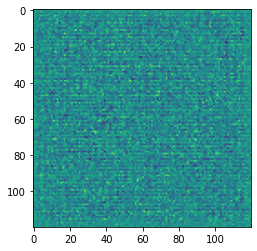

In [ ]:
#Creating an image using the untrained generator
generator = make_generator_model()

noise = tf.random.normal([1, 128])
generated_image = generator(noise, training=False)
print(noise)

plt.imshow(generated_image[0, :, :, 0])

## The Discriminator

In [ ]:
"""def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model"""

def make_discriminator_model():
    model = tf.keras.Sequential(
        [
            tf.keras.Input(shape=(120,120,1)),
            layers.Conv2D(60, kernel_size=4, strides=2, padding='same'),
            layers.LeakyReLU(0.2),
            layers.Conv2D(120, kernel_size=4, strides=2, padding='same'),
            layers.LeakyReLU(0.2),
            layers.Conv2D(120, kernel_size=4, strides=2, padding='same'),
            layers.LeakyReLU(0.2),
            layers.Flatten(),
            layers.Dropout(0.2),
            layers.Dense(1, activation='sigmoid'),
        ]
    )
    return model

make_discriminator_model().summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 60, 60)        1020      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 60, 60, 60)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 120)       115320    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 30, 30, 120)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 120)       230520    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 15, 15, 120)       0         
                                                                 
 flatten (Flatten)           (None, 27000)            

In [ ]:
#Using the untrained discriminator to classify the untrained generated image
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.48454547]], shape=(1, 1), dtype=float32)


## Losses and Optimisers - Generator and Discriminator


In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training Loop

In [ ]:
EPOCHS = 200
noise_dim = 128
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    print(time.strftime("%H:%M:%S", time.localtime()))

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec at {}'.format(epoch + 1, time.time()-start, time.strftime("%H:%M:%S", time.localtime())))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  #plt.savefig('image_at_epoch_{:04d}_at_{time.strftime("%H:%M:%S", time.localtime())}.png'.format(epoch))
  plt.show()

In [ ]:
#Restores last checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Training the Model

In [ ]:
import time

In [ ]:
train(train_dataset, EPOCHS)

KeyboardInterrupt: ignored

## Displaying Images

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
predict_image = generator.predict(tf.random.normal([100, 128]))
generator.save(f'generator_save_50_epoch_{time.strftime("%H:%M:%S", time.localtime())}')

In [ ]:
fig, ax = plt.subplots(ncols=10, nrows=10, figsize=(120,120))
for r in range(10):
    for c in range(10):
        ax[r][c].imshow(predict_image[(r+1)*(c+1)-1])